"""
Copyright 2026 Zsolt Bedőházi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from classic_mil import Feature_attention
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
from sklearn.metrics import precision_recall_curve, average_precision_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc as calc_auc
from sklearn.calibration import calibration_curve
import random
import glob
import h5py
import shutil

from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import patches

#import scienceplots
import seaborn as sns

import copy
#from openslide import OpenSlide
import torchvision.transforms as transforms

from omegaconf import OmegaConf

In [2]:
if torch.cuda.is_available():
    DEVICE = 'cuda:0' 
else:
    DEVICE = 'cpu'
print("Device:", DEVICE)

Device: cuda:0


In [ ]:
conf_preproc = OmegaConf.load("../../../conf/preproc.yaml")
conf_preproc = conf_preproc["project_mil"]

run_nr = "run_sote_sqrt_paper_rev_tuned"

model_selection_metric = "val_loss"

conf_train = OmegaConf.load(f"<YOUR_PATH>/03_training/sote_finetuned_uni_224_224_patches_paper_patients_rev/runs/{run_nr}/experiment_0/conf_train.yaml")

In [ ]:
conf_train.results_dir

In [5]:
run = 0

## Load models from CV folds

#### locate directory with saved checkpoints 

In [6]:
checkpoints_dir_cv_0 = conf_train.results_dir+f'experiment_{run}/cv_0/'
checkpoints_dir_cv_1 = conf_train.results_dir+f'experiment_{run}/cv_1/'
checkpoints_dir_cv_2 = conf_train.results_dir+f'experiment_{run}/cv_2/'
checkpoints_dir_cv_3 = conf_train.results_dir+f'experiment_{run}/cv_3/'
checkpoints_dir_cv_4 = conf_train.results_dir+f'experiment_{run}/cv_4/'

In [ ]:
checkpoints_dir_cv_2

In [8]:
file_names_all_cv = np.array([ np.array( sorted(  glob.glob( os.path.join(eval(f"checkpoints_dir_cv_{i}"), "*.pt"))   )) for i in range(5) ], dtype=object)
file_names_all_cv.shape

(5, 50)

In [9]:
file_names_all_cv[4].shape

(50,)

## Load biopsy bags -> input data

In [ ]:
conf_train.cv_split_dir

In [ ]:
biopsy_bag_input_path = conf_preproc.uni_finetuned_biopsy_dir_macenko_new_bracs

biopsy_df_local_test = pd.read_csv( conf_train.cv_split_dir+'test_split_multi_stratified.csv', dtype={"base_slide_number": str})
biopsy_df_local_test.sort_values('base_slide_number', inplace=True)
biopsy_bag_input_files_local_test = np.array( sorted([ biopsy_bag_input_path + str(i) +'.h5' for i in biopsy_df_local_test.base_slide_number.values ]) )

biopsy_bag_input_files_local_test.shape, biopsy_bag_input_files_local_test[:5]

## Look for best models based on AUC or VAL LOSS

In [12]:
best_models_on_val_auc = []

for i in range(file_names_all_cv.shape[0]):
    # only first best models
    #max_auc_index = np.argmax([float(os.path.basename(item).split('_')[3]) for item in file_names_all_cv[i]])
    
    # multiple best models
    select = 1
    max_auc_sort_index = np.argsort([float(os.path.basename(item).split('_')[7]) for item in file_names_all_cv[i]])[::-1]
    
    for m in range(select):
        max_auc_model = file_names_all_cv[i][max_auc_sort_index[m]]
        best_models_on_val_auc.append(max_auc_model)

best_models_on_val_auc = np.array(best_models_on_val_auc)

In [ ]:
best_models_on_val_auc

In [14]:
best_models_on_val_loss = []

for i in range(file_names_all_cv.shape[0]):
    # only first best models
    #max_auc_index = np.argmax([float(os.path.basename(item).split('_')[3]) for item in file_names_all_cv[i]])
    
    # multiple best models
    select = 1
    min_loss_sort_index = np.argsort([float(os.path.basename(item).split('_')[5]) for item in file_names_all_cv[i]])
    
    for m in range(select):
        min_loss_model = file_names_all_cv[i][min_loss_sort_index[m]]
        best_models_on_val_loss.append(min_loss_model)

best_models_on_val_loss = np.array(best_models_on_val_loss)

In [ ]:
best_models_on_val_loss

In [16]:
os.makedirs("saved_sote_models_uni_finetuned_val_loss_rev", exist_ok=True)
np.savetxt( '__RUN__copy_sote_models_here_uni_finetuned_val_loss_rev.sh', np.array([ 'cp -rp '+ k + '  ./saved_sote_models_uni_finetuned_val_loss_rev/' for k in best_models_on_val_loss ]), fmt='%s')

#os.makedirs("saved_sote_models_uni_finetuned_val_auc_rev", exist_ok=True)
#np.savetxt( '__RUN__copy_models_here_uni_finetuned_val_auc_rev.sh', np.array([ 'cp -rp '+ k + '  ./saved_sote_models_uni_finetuned_val_auc_rev/' for k in best_models_on_val_auc ]), fmt='%s')

In [17]:
! sh __RUN__copy_sote_models_here_uni_finetuned_val_loss_rev.sh

#! sh __RUN__copy_models_here_uni_finetuned_val_auc_rev.sh

In [18]:
! zip -r saved_sote_models_uni_finetuned_val_loss_rev.zip saved_sote_models_uni_finetuned_val_loss_rev/

#! zip -r saved_sote_models_uni_finetuned_val_auc_rev.zip saved_sote_models_uni_finetuned_val_auc_rev/

  adding: saved_sote_models_uni_finetuned_val_loss_rev/ (stored 0%)
  adding: saved_sote_models_uni_finetuned_val_loss_rev/epoch_9_trainloss_0.651_valloss_0.652_auc_0.628_0.7_0.677_0.507_checkpoint.pt (deflated 9%)
  adding: saved_sote_models_uni_finetuned_val_loss_rev/epoch_15_trainloss_0.607_valloss_0.613_auc_0.644_0.726_0.639_0.569_checkpoint.pt (deflated 8%)
  adding: saved_sote_models_uni_finetuned_val_loss_rev/epoch_31_trainloss_0.509_valloss_0.544_auc_0.712_0.767_0.626_0.743_checkpoint.pt (deflated 8%)
  adding: saved_sote_models_uni_finetuned_val_loss_rev/epoch_24_trainloss_0.564_valloss_0.614_auc_0.671_0.75_0.717_0.546_checkpoint.pt (deflated 8%)
  adding: saved_sote_models_uni_finetuned_val_loss_rev/epoch_39_trainloss_0.429_valloss_0.492_auc_0.769_0.894_0.71_0.702_checkpoint.pt (deflated 8%)


##### best models on val loss

In [19]:
np.mean([float(e.split('_auc_')[1].split('_')[0]) for e in best_models_on_val_loss])

np.float64(0.6848000000000001)

##### best models on val auc

In [20]:
np.mean([float(e.split('_auc_')[1].split('_')[0]) for e in best_models_on_val_auc])

np.float64(0.7018000000000001)

## Predict with model ensemble

In [21]:
def load_h5_file_biopsy_bag(filename):
    with h5py.File(filename, "r") as f:
        features = f['features'][()]
        coords = f['coords'][()]
        slides = f['slides'][()]
        label = f['label'][()]
        return features, coords, slides, label

In [22]:
def plot_roc(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # try to one-hot encode y_true
        y_true = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 3)

    plt.figure(figsize=(6, 6))
    auc_all = []
    for class_ind in range(y_pred.shape[-1]):
        fpr, tpr, _ = roc_curve(y_true[:, class_ind], y_pred[:, class_ind])
        auc = roc_auc_score(y_true[:, class_ind], y_pred[:, class_ind])
        auc_all.append(auc)
        plt.plot(fpr, tpr, '-', label='AUC : %.3f, label : %d' % (auc, class_ind+1))
    plt.legend()
    plt.show()
    return auc_all

In [23]:
def plot_precision_recall(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # One-hot encode y_true
        y_true = label_binarize(y_true, classes=range(y_pred.shape[-1]))

    plt.figure(figsize=(6, 6))
    ap_all = []
    for class_ind in range(y_pred.shape[-1]):
        precision, recall, _ = precision_recall_curve(y_true[:, class_ind], y_pred[:, class_ind])
        average_precision = average_precision_score(y_true[:, class_ind], y_pred[:, class_ind])
        ap_all.append(average_precision)
        plt.plot(recall, precision, '-', label='AP: %.3f, Label: %d' % (average_precision, class_ind))
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return ap_all

In [24]:
def pred_with_one_model(model, biopsy_bag_input_files):
    
    preds_all = []
    labels_all = []
    att_weight_all = []

    for b in range(biopsy_bag_input_files.shape[0]):

        with torch.no_grad():
            
            emb_npy, coords, slides, labels = load_h5_file_biopsy_bag( biopsy_bag_input_files[b] )
            #emb_npy = np.load( biopsy_bag_input_files[b] )['embedding']

            #if emb_npy.shape[0] > 15000:
            #    rand_idx = np.random.permutation(emb_npy.shape[0])
            #    emb_npy = emb_npy[rand_idx[:15000]]

            emb = torch.from_numpy(np.expand_dims(emb_npy, 0).astype(np.float32)).to(DEVICE)
            _, preds, label, att_weight = model(emb)


        preds_all.append(preds.cpu().detach().numpy())
        labels_all.append(label.cpu().numpy())
        att_weight_all.append(att_weight.cpu().numpy().flatten())
        
    preds_all = np.concatenate(preds_all)
    labels_all = np.concatenate(labels_all)
    
    return preds_all, labels_all, att_weight_all

### Local test set

In [25]:
if model_selection_metric == "val_auc":
    best_models_on_selected_metric = best_models_on_val_auc
elif model_selection_metric == "val_loss":
    best_models_on_selected_metric = best_models_on_val_loss
else:
    print("Set val_auc or val_loss")

In [26]:
nr_models = best_models_on_selected_metric.shape[0]

preds_ensemble_local_test = np.zeros((best_models_on_selected_metric.shape[0], biopsy_bag_input_files_local_test.shape[0], 3))
labels_ensemble_local_test = np.zeros((best_models_on_selected_metric.shape[0], biopsy_bag_input_files_local_test.shape[0], 1))
att_weights_local_test = [] # np.zeros((best_models_on_selected_metric.shape[0], biopsy_bag_input_files_local_test.shape[0], 1), dtype=object)


for m in tqdm(range(nr_models)):
    
    model = Feature_attention( conf_train.emb_dim, 
                               conf_train.hidden_dim, 
                               conf_train.att_hidden_dim,
                               conf_train.dropout_fc,
                               conf_train.dropout_attn, 
                               conf_train.n_classes).to(DEVICE)
    best_model_path = best_models_on_selected_metric[m] # path of the m th best model
    print(os.path.basename(best_model_path))
    model_state_dict = torch.load(best_model_path, map_location=torch.device('cpu'), weights_only=True) # load

    model.load_state_dict(model_state_dict) # load weights
    model.eval() # set to eval mode ! 
    model.to(DEVICE)
    
    preds_all, labels_all, att_weights_all = pred_with_one_model(model, biopsy_bag_input_files_local_test)
    
    preds_ensemble_local_test[m] = preds_all
    labels_ensemble_local_test[m] = labels_all
    att_weights_local_test.append(att_weights_all)
    
att_weights_local_test = np.array( att_weights_local_test, dtype=object)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch_31_trainloss_0.509_valloss_0.544_auc_0.712_0.767_0.626_0.743_checkpoint.pt


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

epoch_24_trainloss_0.564_valloss_0.614_auc_0.671_0.75_0.717_0.546_checkpoint.pt


 40%|████      | 2/5 [00:02<00:03,  1.17s/it]

epoch_9_trainloss_0.651_valloss_0.652_auc_0.628_0.7_0.677_0.507_checkpoint.pt


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

epoch_15_trainloss_0.607_valloss_0.613_auc_0.644_0.726_0.639_0.569_checkpoint.pt


 80%|████████  | 4/5 [00:03<00:00,  1.80it/s]

epoch_39_trainloss_0.429_valloss_0.492_auc_0.769_0.894_0.71_0.702_checkpoint.pt


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


In [27]:
preds_ensemble_local_test.shape, labels_ensemble_local_test.shape, att_weights_local_test.shape

((5, 72, 3), (5, 72, 1), (5, 72))

In [28]:
np.save(f'preds_sote_5ensemble_level4_macenko_uni_finetuned_{run_nr}_{model_selection_metric}_local_test_rev.npy', preds_ensemble_local_test)
print(f"Saved: preds_sote_5ensemble_level4_macenko_uni_finetuned_{run_nr}_{model_selection_metric}_local_test_rev.npy")

Saved: preds_sote_5ensemble_level4_macenko_uni_finetuned_run_sote_sqrt_paper_rev_tuned_val_loss_local_test_rev.npy


In [29]:
preds_ensemble_local_test = np.load(f'preds_sote_5ensemble_level4_macenko_uni_finetuned_{run_nr}_{model_selection_metric}_local_test_rev.npy')


#### Simple mean

In [30]:
final_pred_ensemble_local_test = np.mean(preds_ensemble_local_test, axis=0)
final_label_ensemble_local_test = np.argmax(preds_ensemble_local_test, axis=-1)
final_pred_ensemble_local_test.shape, final_label_ensemble_local_test.shape

((72, 3), (5, 72))

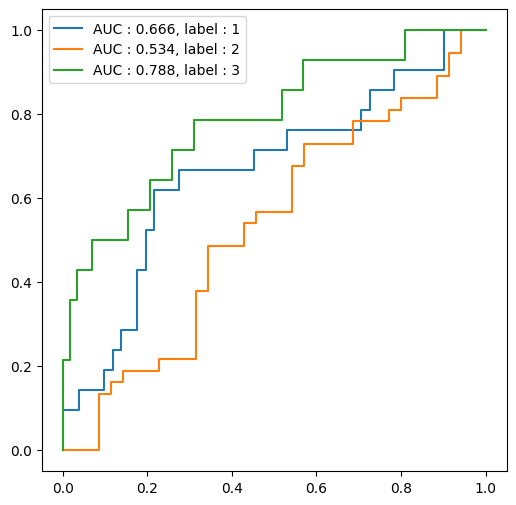

0.6627577447050063


In [31]:
auc_scores = plot_roc( biopsy_df_local_test.clinical_stage.values-1, final_pred_ensemble_local_test  )
print( np.mean(auc_scores) )

In [32]:
print("ROC AUC macro: ", roc_auc_score(biopsy_df_local_test.clinical_stage.values-1, final_pred_ensemble_local_test, multi_class="ovr", average="macro"))
print("ROC AUC weighted: ", roc_auc_score(biopsy_df_local_test.clinical_stage.values-1, final_pred_ensemble_local_test, multi_class="ovr", average="weighted"))

ROC AUC macro:  0.6627577447050063
ROC AUC weighted:  0.622031992873778


### VALIDATION SETS

In [39]:
preds_val_folds = {}


for m in tqdm(range(5)): # 5 folds
    
    biopsy_bag_input_path = conf_preproc.uni_finetuned_biopsy_dir_macenko_new_bracs
    
    val_df = pd.read_csv(f'{conf_train["cv_split_dir"]}val_split_multi_stratified_{m}.csv', dtype={"base_slide_number": str})
    val_df.sort_values('base_slide_number', inplace=True)
    val_df_input_files_local_test = np.array( sorted([ biopsy_bag_input_path + str(i) +'.h5' for i in val_df.base_slide_number.values ]) )

    #print(val_df_input_files_local_test.shape)
    
    model = Feature_attention( conf_train.emb_dim, 
                               conf_train.hidden_dim, 
                               conf_train.att_hidden_dim,
                               conf_train.dropout_fc,
                               conf_train.dropout_attn, 
                               conf_train.n_classes).to(DEVICE)
    
    best_model_path = best_models_on_selected_metric[m] # path of the m th best model
    
    print(os.path.basename(best_model_path))
    
    model_state_dict = torch.load(best_model_path, map_location=torch.device('cpu'), weights_only=True) # load

    model.load_state_dict(model_state_dict) # load weights
    model.eval() # set to eval mode ! 
    model.to(DEVICE)
    
    preds_all, labels_all, att_weights_all = pred_with_one_model(model, val_df_input_files_local_test)
    
    preds_val_folds[f'val_fold_{m}'] = preds_all
    
    #break

  0%|          | 0/5 [00:00<?, ?it/s]

epoch_31_trainloss_0.509_valloss_0.544_auc_0.712_0.767_0.626_0.743_checkpoint.pt


 20%|██        | 1/5 [00:00<00:01,  2.24it/s]

epoch_24_trainloss_0.564_valloss_0.614_auc_0.671_0.75_0.717_0.546_checkpoint.pt


 40%|████      | 2/5 [00:00<00:01,  2.34it/s]

epoch_9_trainloss_0.651_valloss_0.652_auc_0.628_0.7_0.677_0.507_checkpoint.pt


 60%|██████    | 3/5 [00:01<00:00,  2.36it/s]

epoch_15_trainloss_0.607_valloss_0.613_auc_0.644_0.726_0.639_0.569_checkpoint.pt


 80%|████████  | 4/5 [00:01<00:00,  2.21it/s]

epoch_39_trainloss_0.429_valloss_0.492_auc_0.769_0.894_0.71_0.702_checkpoint.pt


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


In [40]:
val_df.shape

(42, 19)

In [41]:
preds_val_folds.keys()

dict_keys(['val_fold_0', 'val_fold_1', 'val_fold_2', 'val_fold_3', 'val_fold_4'])

In [42]:
preds_val_folds['val_fold_4'].shape

(42, 3)

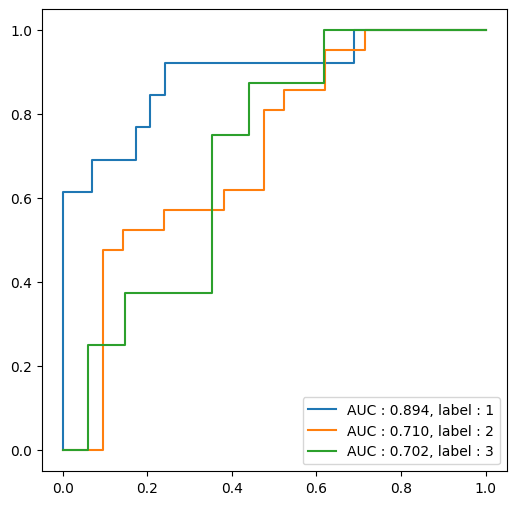

0.7686185511634657


In [43]:
# checking
#val_df = pd.read_csv(f'{conf_train["cv_split_dir"]}val_split_multi_stratified_{4}.csv', dtype={"base_slide_number": str})
#val_df.sort_values('base_slide_number', inplace=True)

auc_val = plot_roc( val_df.clinical_stage.values-1, preds_val_folds['val_fold_4']  )
print( np.mean(auc_val) )

In [44]:
np.savez(f'preds_sote_5ensemble_level4_macenko_uni_finetuned_{run_nr}_{model_selection_metric}_val_folds_rev.npz', **preds_val_folds)
print(f"Saved: preds_sote_5ensemble_level4_macenko_uni_finetuned_{run_nr}_{model_selection_metric}_val_folds_rev.npz")

Saved: preds_sote_5ensemble_level4_macenko_uni_finetuned_run_sote_sqrt_paper_rev_tuned_val_loss_val_folds_rev.npz


In [45]:
loaded = np.load(f'preds_sote_5ensemble_level4_macenko_uni_finetuned_{run_nr}_{model_selection_metric}_val_folds_rev.npz')
list(loaded.keys())

['val_fold_0', 'val_fold_1', 'val_fold_2', 'val_fold_3', 'val_fold_4']